In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, concatenate, add

from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [0]:
DATA_PATH = '/content/drive/My Drive/HW4/cifar-10-batches-py/'
IMG_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

In [0]:
def loadCIFAR10(val_size = 0.2):
    
    
    BATCH_SIZE = 10000
    CHANNEL_SIZE = IMG_SIZE * IMG_SIZE
    
    
    
    x_train = np.zeros((BATCH_SIZE*5,IMG_SIZE,IMG_SIZE,N_CHANNELS))
    y_train = np.zeros((BATCH_SIZE*5,N_CLASSES))
    
    files = os.listdir(DATA_PATH)
    
    for f in files:
        if f[:11] == 'data_batch_':
            
            n_batch = int(f[11])
            batch = unpickle(DATA_PATH + f)
            
            data = batch[b'data']
            
            redChannels = data[:, : CHANNEL_SIZE].reshape((BATCH_SIZE,IMG_SIZE,IMG_SIZE))
            greenChannels = data[:, CHANNEL_SIZE : 2 * CHANNEL_SIZE].reshape((BATCH_SIZE,IMG_SIZE,IMG_SIZE))
            blueChannels = data[:,2 * CHANNEL_SIZE :].reshape((BATCH_SIZE,IMG_SIZE,IMG_SIZE))
            
            x_train_batch = np.stack([redChannels,greenChannels,blueChannels],axis= 3)
            
            x_train[(n_batch - 1) * BATCH_SIZE : n_batch * BATCH_SIZE,:,:,:] = x_train_batch
            
            labels = to_categorical(np.array(batch[b'labels']),num_classes= N_CLASSES)
            y_train[(n_batch - 1) * BATCH_SIZE : n_batch * BATCH_SIZE] = labels
        
        if f == 'test_batch':
            
            test = unpickle(DATA_PATH + f)
            
            data = test[b'data']
            redChannels = data[:, : CHANNEL_SIZE].reshape((BATCH_SIZE,IMG_SIZE,IMG_SIZE))
            greenChannels = data[:, CHANNEL_SIZE : 2 * CHANNEL_SIZE].reshape((BATCH_SIZE,IMG_SIZE,IMG_SIZE))
            blueChannels = data[:,2 * CHANNEL_SIZE :].reshape((BATCH_SIZE,IMG_SIZE,IMG_SIZE))
            
            x_test = np.stack([redChannels,greenChannels,blueChannels],axis= 3)
            
            y_test = to_categorical(np.array(test[b'labels']),num_classes= N_CLASSES)
        
    
    # Normalize data
    x_train = x_train/255
    x_test = x_test/255
    
    # Split in train - val sets
    valSize = int(val_size * x_train.shape[0])
    x_val = x_train[:valSize,:,:,:]
    y_val = y_train[:valSize,:]

    x_train = x_train[valSize:,:,:,:]
    y_train = y_train[valSize:,:]
    
    return x_train, y_train, x_val, y_val, x_test, y_test
            

In [0]:
x_train, y_train, x_val, y_val, x_test, y_test = loadCIFAR10(val_size=0.2)

In [7]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 10)
x_val shape: (10000, 32, 32, 3)
y_val shape: (10000, 10)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


## Model 

In [0]:
def build_model():
    
    model = Sequential()
  
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE,N_CHANNELS)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer = 'l2'))
    model.add(Dropout(0.25))
    model.add(Dense(N_CLASSES, activation='softmax')) 
        
    model.summary()
    return model

In [0]:
def advanceModel(_type):
    
    X = Input(shape=(IMG_SIZE, IMG_SIZE,N_CHANNELS))
    
    if(_type == 'inception'):
        
        
        branch_a = Conv2D(64, (3, 3), activation='relu')(X)
        branch_a = MaxPooling2D(pool_size=(2, 2))(branch_a)
        branch_a = Conv2D(128, (3, 3),padding = 'same',activation='relu')(branch_a)
        
        branch_b = Conv2D(32, (1, 1), activation='relu')(X)
        branch_b = MaxPooling2D(pool_size=(2, 2))(branch_b)
        branch_b = Conv2D(64, (2, 2),activation='relu')(branch_b)
        
        inception = concatenate([branch_a,branch_b],axis = -1)

        
        dense = Flatten()(inception)
        dense = Dense(512, activation='relu', kernel_regularizer = 'l2')(dense)
        dense = Dropout(0.25)(dense)
        
        output = Dense(N_CLASSES, activation='softmax')(dense)
        
        
        model = Model(X,output)

        model.summary()
        return model

    if(_type == 'residual'):
        
        
        y = Conv2D(64, (3, 3), padding='same', activation='relu')(X)
        y = Conv2D(128, (3, 3),padding = 'same', activation='relu')(y)
        y = Conv2D(128, (3, 3),padding = 'same', activation='relu')(y)
        
        residual = Conv2D(128,(1,1),padding='same')(X)
        x2 = add([y,residual])

        y2 = Conv2D(128, (3, 3), padding='same',activation='relu')(x2)
        y2 = MaxPooling2D(pool_size=(2, 2),strides = 2)(y2)

        residual2 = Conv2D(128, (1, 1),strides=2,padding='same')(x2)
        
        x3 = add([y2,residual2])        
        
        dense = Flatten()(x3)
        dense = Dense(512, activation='relu',kernel_regularizer='l2')(dense)
        output = Dense(N_CLASSES, activation='softmax')(dense)
        
        model = Model(X,output)
        model.summary()
        return model


### Optimizing Hyperparameters

In [0]:
def modelEvaluation(advModel = False,_type = None, optimizer='adam',loss = 'categorical_crossentropy',epochs=16,batch_size=32, plot=True): 
    
    if advModel:
        model = advanceModel(_type)
    else:
        model = build_model()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  
    hist = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                     epochs=epochs,verbose=1,batch_size=batch_size)
    
    model.save(DATA_PATH + 'model_epochs_{}_optimizer_{}_batch_{}.h5'.format(epochs,optimizer,batch_size))
    if(plot):
        print("------------Epochs: {}------------".format(epochs))
        #Visualize the models accuracy
        plt.plot(hist.history['accuracy'])
        plt.plot(hist.history['val_accuracy'])
        plt.title('Accuracy {}'.format(model.name))
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper left')
        plt.show()

        #Visualize the models loss
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['val_loss'])
        plt.title('Loss {}'.format(model.name))
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper left')
        plt.show()
    
    loss_train = hist.history['loss'][-1]
    acc_train = hist.history['accuracy'][-1]
    loss_val = hist.history['val_loss'][-1]
    acc_val = hist.history['val_accuracy'][-1]
    
    print("Loss-> Train Set:{:.2f}; Test Set:{:.2f} (Diff: {:2f})".format(loss_train,loss_val,abs(loss_train-loss_val)))
    print("Accuracy-> Train Set:{:.2f}; Test Set:{:.2f} (Diff: {:2f})".format(acc_train,acc_val,abs(acc_train-acc_val)))
    
    return loss_train, acc_train, loss_val, acc_val
    
   

In [0]:
epochs = [16,32,64]
batch_sizes = [16,32]
#optimizers = ['sgd','RMSprop','adagrad','adam','adadelta']
optimizers = ['adam']

In [13]:
results = pd.DataFrame(columns=['Optimizer','epochs','batch_sizes','loss_train', 'acc_train', 'loss_val', 'acc_val'])
results

Empty DataFrame
Columns: [Optimizer, epochs, batch_sizes, loss_train, acc_train, loss_val, acc_val]
Index: []

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 128)        

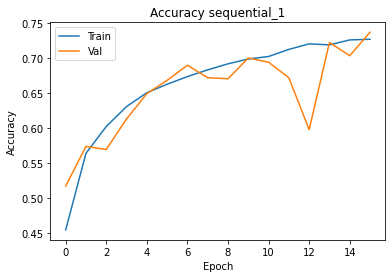

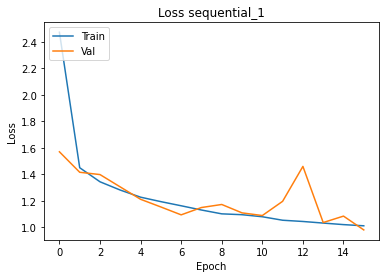

Loss-> Train Set:1.01; Test Set:0.98 (Diff: 0.031073)
Accuracy-> Train Set:0.73; Test Set:0.74 (Diff: 0.010025)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)          0         
________

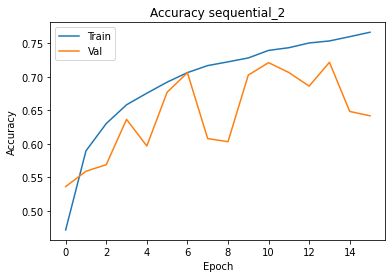

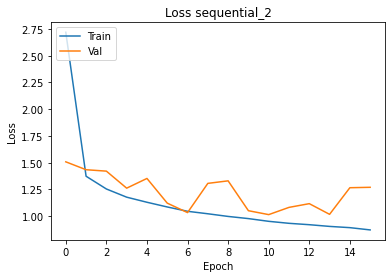

Loss-> Train Set:0.87; Test Set:1.27 (Diff: 0.398164)
Accuracy-> Train Set:0.77; Test Set:0.64 (Diff: 0.124350)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 64)          0         
________

KeyboardInterrupt: ignored

In [19]:
for optimizer in optimizers:
    for epoch in epochs:
        for batch_size in batch_sizes:
            loss_train, acc_train, loss_val, acc_val = modelEvaluation(optimizer=optimizer,epochs=epoch,batch_size=batch_size)
            results = results.append({'Optimizer':optimizer,'epochs':epoch,'batch_sizes':batch_size,'loss_train':loss_train, 'acc_train':acc_train, 'loss_val':loss_val, 'acc_val':acc_val},ignore_index=True)

In [0]:
results

**Test Set**

In [0]:
model = build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights(DATA_PATH + 'model_epochs_64_optimizer_adam_batch_16.h5')

In [0]:
model.evaluate(x_test,y_test)

### Inception and Residual Blocks 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 30, 30, 64)   1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 32, 32)   128         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 15, 15, 64)   0           conv2d_11[0][0]                  
______________________________________________________________________________________________

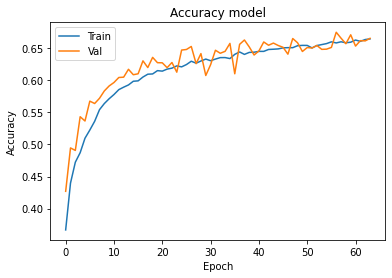

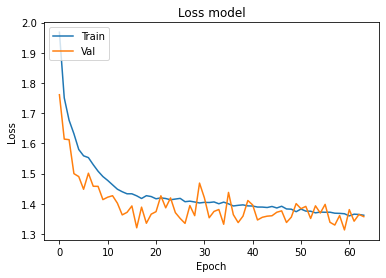

Loss-> Train Set:1.36; Test Set:1.36 (Diff: 0.004631)
Accuracy-> Train Set:0.66; Test Set:0.67 (Diff: 0.000900)


(1.3620691299438477,
 0.6646999716758728,
 1.3574378490447998,
 0.6656000018119812)

In [17]:
modelEvaluation(advModel=True,_type='inception',optimizer='adam',epochs=64,batch_size=16)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 32, 32, 64)   1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 32, 32, 128)  73856       conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 32, 32, 128)  147584      conv2d_16[0][0]                  
____________________________________________________________________________________________

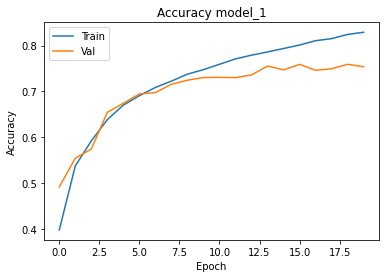

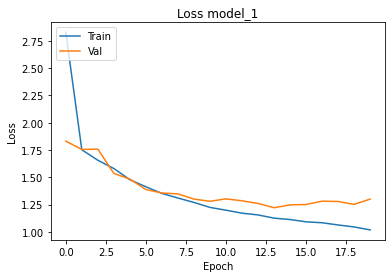

Loss-> Train Set:1.02; Test Set:1.30 (Diff: 0.282552)
Accuracy-> Train Set:0.83; Test Set:0.75 (Diff: 0.075075)


(1.0173572301864624,
 0.8288750052452087,
 1.2999094724655151,
 0.7537999749183655)

In [18]:
modelEvaluation(advModel=True,_type='residual',optimizer='adam',epochs=30,batch_size=128)